# Indirect Method for simple double integral system
Yuri Shimane, 2020/08/18

Problem is given in Kirk example 5.6-3 (pg.300~), but for a modified cost function. The system is described by

$$
\begin{align}
\dot{x}_1(t) = x_2(t)  \\
\dot{x}_2(t) = u(t)
\end{align}
$$

with bounds on the control

$$
\left| u \right| \leq 1.0
$$

Considering a minimum time problem

$$
J = \int_{0}^{t_f} dt
$$

the Hamiltonian is given by

$$
H = 1 + p_1(t)x_2(t) + p_2(t)u(t)
$$

In [1]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

#### House ```solve_bvp``` in customized function
Since the BVP is solved a few times with decreasing value of $\mu$, the setup and call of the ```solve_bvp``` function is wrapped into a customized function, taking $\mu$ and initial guess of mesh and parameter ($t_f$) as inputs. 

In [2]:
def solve_doubleIntegral_bvp(mu, x_guess, y_guess, p_guess):
    """Function wraps solve_bvp function for double integral problem, solved for specific value of mu"""
    
    # define ODE's
    def ode_doubleIntegral(t, y, p):
        """ODE function must return array with shape (n,m), in the same layout as y"""
        tf = p[0]
        n, m = y.shape
        for j in range(m):
            state = y[:,j]
            # unpack state
            x1 = state[0]
            x2 = state[1]
            p1 = state[2]
            p2 = state[3]
            # derivatives
            dstate = np.zeros(n,)
            dstate[0] = tf*( x2 + mu*p1/np.sqrt(mu*p1**2 + p2**2) )
            dstate[1] = tf*( p2/np.sqrt(mu*p1**2 + p2**2) )
            dstate[2] = tf*( 0 )
            dstate[3] = tf*( -p1 )
            if j == 0:
                dy = np.reshape(dstate, (n,1))
            else:
                dy = np.concatenate((dy, np.reshape(dstate, (n,1)) ), axis=1)
        return dy
    
    # define boundary values
    def bc_doubleIntegral(ya, yb, p):
        """Boundary conditions must have shape (n+k,), where ya & yb have shape (n,), and p has shape (k,)"""
        res = np.zeros(len(ya)+len(p),)
        # initial time boundary conditions
        res[0] = ya[0] - 2   # x_1(0) == 2
        res[1] = ya[1] - 2   # x_2(0) == 2
        # final time boundary conditions
        res[2] = yb[0]       # x1(t_f) == 0
        res[3] = yb[1]       # x2(t_f) == 0
        res[4] = yb[2]**2 + yb[3]**2 - 1    # p1(tf)^2 + p2(tf)^2 - 1 = 0
        return res
    
    # call solve_bvp
    sol = solve_bvp(fun=ode_doubleIntegral, bc=bc_doubleIntegral, x=x_guess, y=y_guess, p=p_guess, 
                    verbose=2, bc_tol=1e-12)
    return sol

#### Initial solution with $\mu$
Start the problem with $\mu=0.5$...

In [3]:
mu_init = 0.5
# prepare time-domain mesh
x_guess = np.linspace(0, 1, 10)
# prepare initial geuss
y_guess = np.zeros((4, x_guess.size))
for j in range(x_guess.size):  # modify initial guess slightly (may be commented out)
    y_guess[0,j] = 2
    y_guess[1,j] = 2
    y_guess[2,j] = 0
    y_guess[3,j] = -1

In [4]:
tf_guess = 4
sol = solve_doubleIntegral_bvp(mu_init, x_guess, y_guess, [tf_guess])

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          6.21e-01       5.98e+00          10             18       
       2          1.43e-03       3.71e-05          28              1       
       3          7.81e-04       6.22e-15          29              0       
Solved in 3 iterations, number of nodes 29. 
Maximum relative residual: 7.81e-04 
Maximum boundary residual: 6.22e-15


#### Successive solution with decreasing values of $\mu$

In [5]:
# unpack sol object for successive solution
def prepare_next_bvpguess(sol):
    """Function unpacks sol object returned by solve_bvp to prepare initial guess for next iteration"""
    xguess_next = sol.x
    yguess_next = sol.y
    p_next = sol.p
    return xguess_next, yguess_next, p_next

In [6]:
xguess_next, yguess_next, p_next = prepare_next_bvpguess(sol)
p_next

array([5.33041246])

In [7]:
mus = [0.3, 0.01]
sols = [sol]  # create list of solutions, with initial sol
for mu in mus:
    print(f"======== Solving BVP with mu = {mu}, using previous solution as inial guess ========")
    xguess_next, yguess_next, p_next = prepare_next_bvpguess(sol)
    sol = solve_doubleIntegral_bvp(mu, xguess_next, yguess_next, p_next)
    # append to list for plotting
    sols.append(sol)

======== Solving BVP with mu = 0.3, using previous solution as inial guess ========
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          7.12e-04       6.02e-11          29              0       
       2          7.12e-04       2.13e-27          29              0       
Solved in 2 iterations, number of nodes 29. 
Maximum relative residual: 7.12e-04 
Maximum boundary residual: 2.13e-27
======== Solving BVP with mu = 0.01, using previous solution as inial guess ========
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          4.25e-02       3.09e-08          29              5       
       2          7.17e-03       3.17e-13          34              3       
       3          3.77e-03       6.88e-15          37              2       
       4          9.79e-04       3.52e-28          39              0       
Solved in 4 iterations, number of nodes 39. 
Maximum relative residual: 9.79e-04 
Maximum boundary residu

In [8]:
sols_unpacked = []
# unpack solutions
for j in range(len(sols)):
    sol = sols[j]
    tf = sol.p
    sol_mesh = sol.x
    sol_mat = sol.y
    times = tf * sol.x
    x1_star = sol_mat[0,:]
    x2_star = sol_mat[1,:]
    p1_star = sol_mat[2,:]
    p2_star = sol_mat[3,:]

    # reconstruct u
    ustar = np.zeros(len(p1_star),)
    for j in range(len(p1_star)):
        ustar[j] = p2_star[j]/np.sqrt(mu*p1_star[j]**2 + p2_star[j]**2)
    
    # save output into list
    sols_unpacked.append(
        {
            "x1_star": x1_star, 
            "x2_star": x2_star, 
            "p1_star": p1_star, 
            "p2_star": p2_star,
            "times": times, 
            "tf": tf, 
            "ustar": ustar
        }
    )

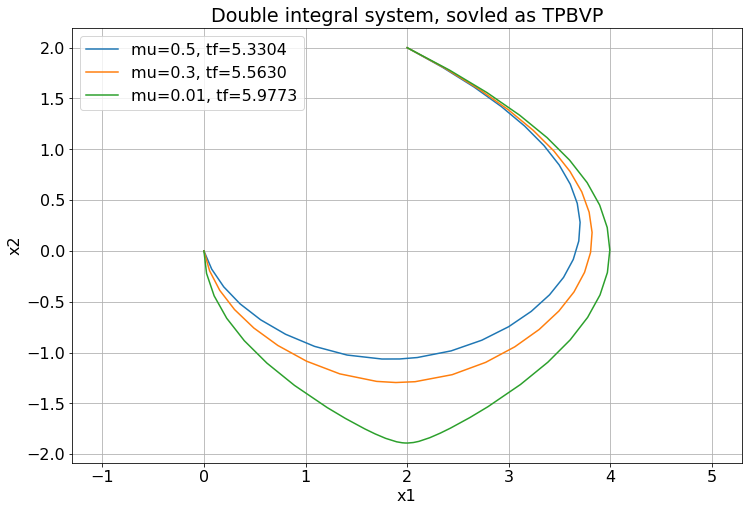

In [9]:
plt.figure(1, figsize=(12,8))
plt.title(f"Double integral system, sovled as TPBVP")

mu_lst = [mu_init] + mus

for j in range(len(sols_unpacked)):
    sol_unpacked = sols_unpacked[j]
    mu_sol = sol_unpacked["tf"][0]
    tf = sol_unpacked["tf"][0]
    plt.plot(sol_unpacked["x1_star"], sol_unpacked["x2_star"], label=f"mu={mu_lst[j]}, tf={tf:2.4f}")
    
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.legend()
plt.grid(which="both")
plt.show()

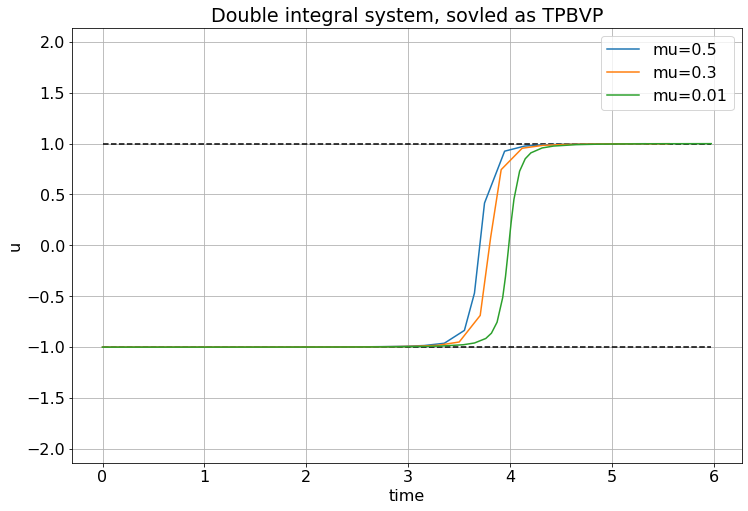

In [10]:
plt.figure(1, figsize=(12,8))
plt.title(f"Double integral system, sovled as TPBVP")
for j in range(len(sols_unpacked)):
    sol_unpacked = sols_unpacked[j]
    plt.plot(sol_unpacked["times"], sol_unpacked["ustar"], label=f"mu={mu_lst[j]}")
plt.hlines(-1, xmin=min(times), xmax=max(times), linestyles='dashed')
plt.hlines(+1, xmin=min(times), xmax=max(times), linestyles='dashed')
plt.xlabel("time")
plt.ylabel("u")
plt.axis("equal")
plt.legend()
plt.grid(which="both")
plt.show()